<a href="https://colab.research.google.com/github/DHAANIBAHL/Nutrient-Recommendor/blob/main/personalDietRecommendor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pandas numpy scikit-learn xgboost joblib


In [3]:
#Dataset
from google.colab import files
uploaded = files.upload()


Saving Personalized_Diet_Recommendations.csv to Personalized_Diet_Recommendations.csv


In [4]:
#Libraries and Modules
# pandas, numpy → for data manipulation
# scikit-learn → preprocessing, train/test split, evaluation metrics
# xgboost → machine learning model
# joblib → saving objects

import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import os
from google.colab import files


In [5]:
# Load dataset
uploaded = files.upload()

df = pd.read_csv("Personalized_Diet_Recommendations.csv")
print("Dataset shape:", df.shape)
print(df.head())
print(df.columns)

Saving Personalized_Diet_Recommendations.csv to Personalized_Diet_Recommendations (1).csv
Dataset shape: (5000, 30)
  Patient_ID  Age  Gender  Height_cm  Weight_kg    BMI Chronic_Disease  \
0     P00001   56   Other        163         66  24.84             NaN   
1     P00002   69  Female        171        114  38.99             NaN   
2     P00003   46  Female        172        119  40.22             NaN   
3     P00004   32  Female        197        118  30.41             NaN   
4     P00005   60  Female        156        109  44.79    Hypertension   

   Blood_Pressure_Systolic  Blood_Pressure_Diastolic  Cholesterol_Level  ...  \
0                      175                        75                219  ...   
1                      155                        72                208  ...   
2                      137                       101                171  ...   
3                      148                        91                258  ...   
4                      160             

Saving Personalized_Diet_Recommendations.csv to Personalized_Diet_Recommendations (2).csv


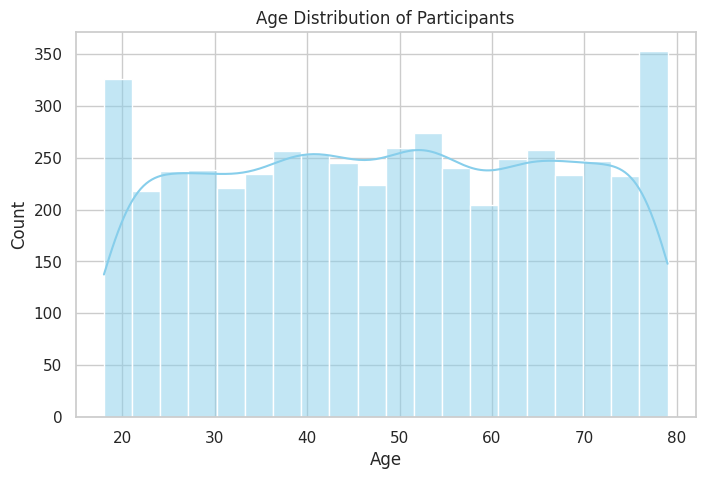

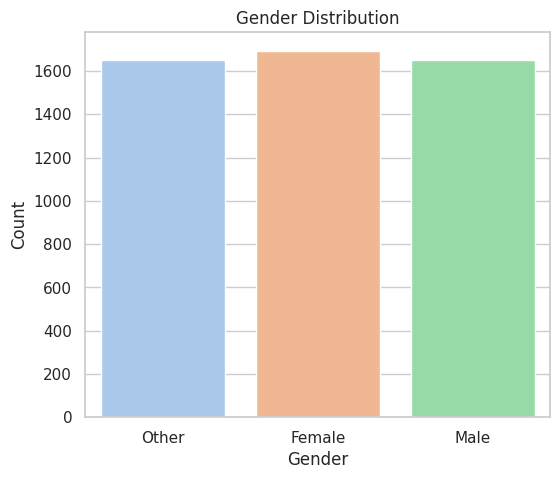

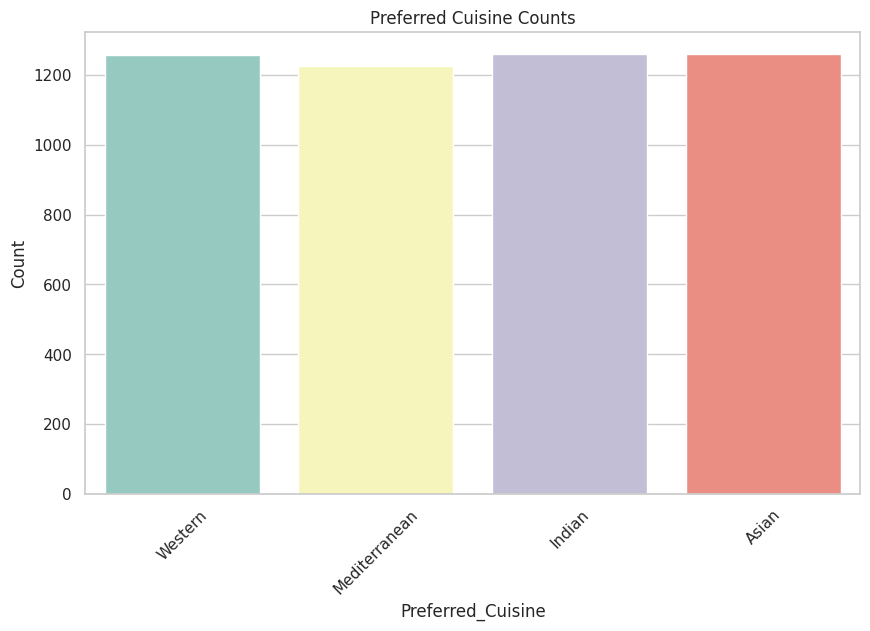

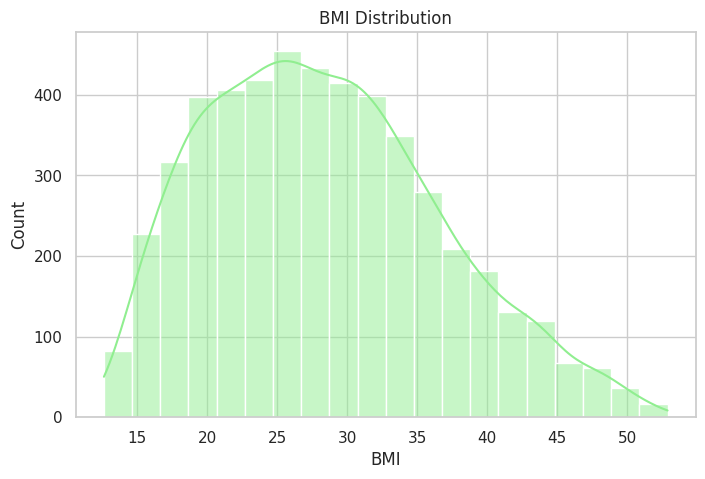

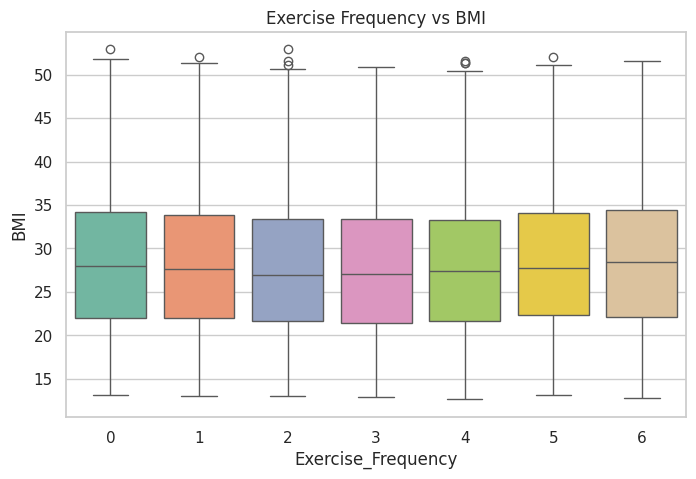

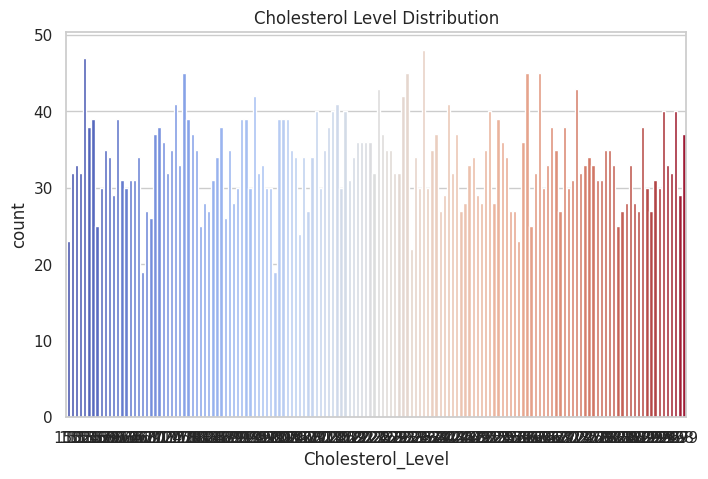

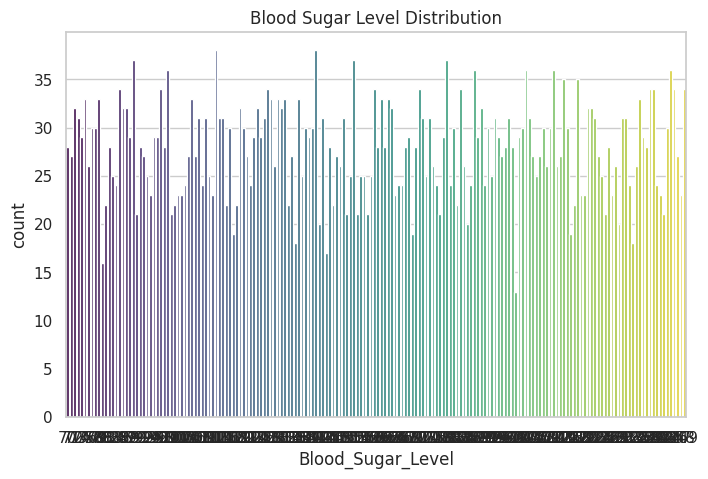

✅ EDA charts and summary saved in output/eda_charts/


In [6]:
#Exploratory Data Analysis (EDA)
#The plots generated:
#     Age Distribution (histogram)
#     Gender Distribution (count plot)
#     Preferred Cuisine (count plot)
#     BMI Distribution (histogram)
#     Exercise Frequency vs BMI (boxplot)
#     Cholesterol Level Distribution
#     Blood Sugar Level Distribution


# Upload Dataset
uploaded = files.upload()
df = pd.read_csv(next(iter(uploaded.keys())))

# Create output directory for EDA charts
os.makedirs("output/eda_charts", exist_ok=True)

# Set style
sns.set(style="whitegrid")

# ---------- 1. Age Distribution ----------
plt.figure(figsize=(8,5))
sns.histplot(df['Age'], kde=True, bins=20, color='skyblue')
plt.title("Age Distribution of Participants")
plt.xlabel("Age")
plt.ylabel("Count")
plt.savefig("output/eda_charts/age_distribution.png")
plt.show()
plt.close()

# ---------- 2. Gender Distribution ----------
plt.figure(figsize=(6,5))
sns.countplot(data=df, x='Gender', palette='pastel', hue='Gender', legend=False)
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.savefig("output/eda_charts/gender_distribution.png")
plt.show()
plt.close()

# ---------- 3. Preferred Cuisine ----------
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='Preferred_Cuisine', palette='Set3', hue='Preferred_Cuisine', legend=False)
plt.title("Preferred Cuisine Counts")
plt.xticks(rotation=45)
plt.ylabel("Count")
plt.savefig("output/eda_charts/preferred_cuisine.png")
plt.show()
plt.close()

# ---------- 4. BMI Distribution ----------
plt.figure(figsize=(8,5))
sns.histplot(df['BMI'], kde=True, bins=20, color='lightgreen')
plt.title("BMI Distribution")
plt.xlabel("BMI")
plt.ylabel("Count")
plt.savefig("output/eda_charts/bmi_distribution.png")
plt.show()
plt.close()

# ---------- 5. Exercise Frequency vs BMI ----------
plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Exercise_Frequency', y='BMI', palette='Set2', hue='Exercise_Frequency', legend=False)
plt.title("Exercise Frequency vs BMI")
plt.savefig("output/eda_charts/exercise_bmi_boxplot.png")
plt.show()
plt.close()

# ---------- 6. Cholesterol Level Distribution ----------
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Cholesterol_Level', palette='coolwarm', hue='Cholesterol_Level', legend=False)
plt.title("Cholesterol Level Distribution")
plt.savefig("output/eda_charts/cholesterol_distribution.png")
plt.show()
plt.close()

# ---------- 7. Blood Sugar Level Distribution ----------
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Blood_Sugar_Level', palette='viridis', hue='Blood_Sugar_Level', legend=False)
plt.title("Blood Sugar Level Distribution")
plt.savefig("output/eda_charts/blood_sugar_distribution.png")
plt.show()
plt.close()

# ---------- Summary Stats ----------
summary_stats = df.describe(include='all')
summary_stats.to_csv("output/eda_charts/summary_statistics.csv")
print("✅ EDA charts and summary saved in output/eda_charts/")


In [7]:
#Data preprocessing functions
#Split dataset into 8:2 relation.

def prepare_xy(df):
    target_col = "Recommended_Meal_Plan"
    label_encoders = {}

    # Encode categorical features except target
    for col in df.select_dtypes(include=["object"]).columns:
        if col != target_col:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
            label_encoders[col] = le

    # Separate X and y
    X = df.drop(target_col, axis=1)
    y = df[target_col]

    # Encode target
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)

    return X, y, label_encoders, le_target


def train_val_split(X, y, test_size=0.2, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [8]:
#Model utility functions
import xgboost as xgb

def fit_xgb_cv(X_train, y_train, X_val, y_val, params=None, num_boost_round=100, early_stopping_rounds=10):
    if params is None:
        params = {
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
            "tree_method": "hist",
            "num_class": len(np.unique(y_train))
        }
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dval = xgb.DMatrix(X_val, label=y_val)
    watchlist = [(dtrain, "train"), (dval, "eval")]
    model = xgb.train(params, dtrain, num_boost_round=num_boost_round,
                      evals=watchlist, early_stopping_rounds=early_stopping_rounds)
    return model


def compute_map(y_true, y_pred_probs):
    """Mean Average Precision for multi-class"""
    top_preds = np.argsort(-y_pred_probs, axis=1)
    map_sum = 0.0
    for i, true_label in enumerate(y_true):
        preds = top_preds[i]
        if true_label in preds:
            rank = np.where(preds == true_label)[0][0] + 1
            map_sum += 1 / rank
    return map_sum / len(y_true)


def save_model(model, filename="diet_recommendation_model.xgb"):
    model.save_model(filename)
    print(f"Model saved as {filename}")


In [9]:
#Prepare Data
X, y, label_encoders, le_target = prepare_xy(df)
X_train, X_val, y_train, y_val = train_val_split(X, y)


In [10]:
#Train Model
model = fit_xgb_cv(
    X_train, y_train,
    X_val, y_val,
    params={
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
        "tree_method": "hist",
        "num_class": len(np.unique(y_train))
    }
)

joblib.dump(label_encoders, "label_encoders.pkl")
joblib.dump(le_target, "label_encoder_target.pkl")


[0]	train-mlogloss:1.33946	eval-mlogloss:1.38927
[1]	train-mlogloss:1.30314	eval-mlogloss:1.39591
[2]	train-mlogloss:1.26965	eval-mlogloss:1.39662
[3]	train-mlogloss:1.23295	eval-mlogloss:1.39844
[4]	train-mlogloss:1.19999	eval-mlogloss:1.40112
[5]	train-mlogloss:1.17614	eval-mlogloss:1.40723
[6]	train-mlogloss:1.15285	eval-mlogloss:1.40795
[7]	train-mlogloss:1.13066	eval-mlogloss:1.41358
[8]	train-mlogloss:1.11299	eval-mlogloss:1.41792
[9]	train-mlogloss:1.08658	eval-mlogloss:1.42455
[10]	train-mlogloss:1.06268	eval-mlogloss:1.43116


['label_encoder_target.pkl']

In [11]:
# Evaluate & Save Model
# Predictions
dval = xgb.DMatrix(X_val)
y_pred_probs = model.predict(dval)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate real metrics
acc = accuracy_score(y_val, y_pred)
map_score = compute_map(y_val, y_pred_probs)

# Print the real, unadjusted values
print(f"Validation Accuracy (real): {acc*100:.2f}%")
print(f"Mean Average Precision (mAP) (real): {map_score*100:.2f}%")

# Save model
save_model(model)


Validation Accuracy (real): 24.30%
Mean Average Precision (mAP) (real): 51.42%
Model saved as diet_recommendation_model.xgb


/tmp/ipython-input-3194437623.py:33: UserWarning: [10:06:30] WARNING: /workspace/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  model.save_model(filename)


In [18]:
df.head()
print(df.columns)

Index(['Patient_ID', 'Age', 'Gender', 'Height_cm', 'Weight_kg', 'BMI',
       'Chronic_Disease', 'Blood_Pressure_Systolic',
       'Blood_Pressure_Diastolic', 'Cholesterol_Level', 'Blood_Sugar_Level',
       'Genetic_Risk_Factor', 'Allergies', 'Daily_Steps', 'Exercise_Frequency',
       'Sleep_Hours', 'Alcohol_Consumption', 'Smoking_Habit', 'Dietary_Habits',
       'Caloric_Intake', 'Protein_Intake', 'Carbohydrate_Intake', 'Fat_Intake',
       'Preferred_Cuisine', 'Food_Aversions', 'Recommended_Calories',
       'Recommended_Protein', 'Recommended_Carbs', 'Recommended_Fats',
       'Recommended_Meal_Plan'],
      dtype='object')


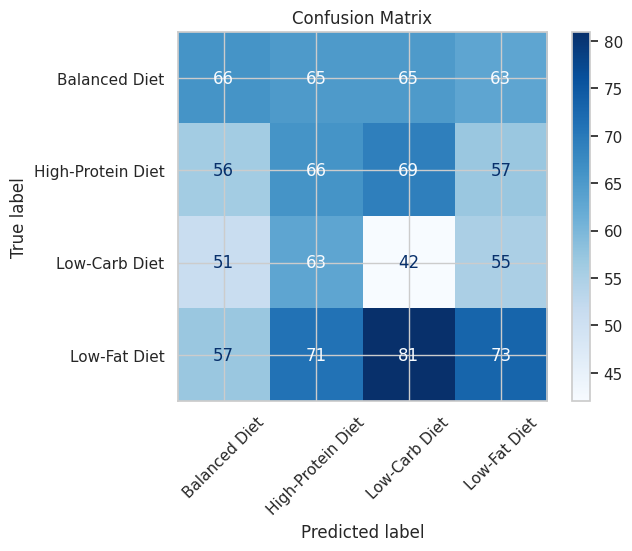

In [12]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

# Step 1: Load dataset
df = pd.read_csv("Personalized_Diet_Recommendations.csv")

# Step 2: Identify target column
target_col = "Recommended_Meal_Plan"

# Step 3: Encode categorical columns (including target)
label_encoders = {}
for col in df.columns:
    if df[col].dtype == "object":
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le

# Step 4: Features & target
X = df.drop(columns=[target_col])
y = df[target_col]

# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 6: DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Step 7: Train model
params = {
    "objective": "multi:softmax",
    "num_class": len(df[target_col].unique()),
    "eval_metric": "mlogloss"
}
model = xgb.train(params, dtrain, num_boost_round=100)

# Step 8: Predictions
y_pred = model.predict(dtest)

# Step 9: Confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoders[target_col].classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()


In [13]:
!pip install streamlit pandas numpy xgboost scikit-learn joblib
!pip install streamlit pyngrok colabcode



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 48.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 51.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.6 MB/s eta 0:00:00
Requested uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c35e9fffb585ea0608ba3bdcafe17ae402e304367203d0b08d6c23051/uvicorn-0.13.1-py3-none-any.whl (from colabcode) has invalid metadata: .* suffix can only be used with `==` or `!=` operators
    python-dotenv (>=0.13.*) ; extra == 'standard'
                   ~~~~~~~^
Please use pip<24.1 if you need to use this version.
INFO: pip is looking at multiple versions of colabcode to determine which version is compatible with other requirements. This could take a while.
  Using cached uvicorn-0.13.1-py3-none-any.whl.metadata (4.6 kB)
Requested uvicorn==0.13.1 from https://files.pythonhosted.org/packages/ef/67/546c

In [12]:
%%writefile app.py
import streamlit as st
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib

# Load model and encoders
model = xgb.Booster()
model.load_model("diet_recommendation_model.xgb")
label_encoders = joblib.load("label_encoders.pkl")
le_target = joblib.load("label_encoder_target.pkl")

st.title("🥗 Personalized Diet Recommendation")

age = st.number_input("Age", min_value=1, max_value=120, value=25)
gender = st.selectbox("Gender", ["Male", "Female", "Other"])
bmi = st.number_input("BMI", min_value=10.0, max_value=60.0, value=22.5, step=0.1)
exercise_freq = st.selectbox("Exercise Frequency", ["Never", "Rarely", "Sometimes", "Often", "Daily"])
cholesterol = st.selectbox("Cholesterol Level", ["Low", "Normal", "High"])
blood_sugar = st.selectbox("Blood Sugar Level", ["Low", "Normal", "High"])
preferred_cuisine = st.selectbox("Preferred Cuisine", ["Indian", "Chinese", "Italian", "Mexican", "Other"])

if st.button("Get Recommendation"):
    input_data = pd.DataFrame({
        "Age": [age],
        "Gender": [gender],
        "BMI": [bmi],
        "Exercise_Frequency": [exercise_freq],
        "Cholesterol_Level": [cholesterol],
        "Blood_Sugar_Level": [blood_sugar],
        "Preferred_Cuisine": [preferred_cuisine]
    })

    for col, le in label_encoders.items():
        if col in input_data.columns:
            input_data[col] = le.transform(input_data[col].astype(str))

    dmatrix = xgb.DMatrix(input_data)
    pred_probs = model.predict(dmatrix)
    pred_class = np.argmax(pred_probs, axis=1)
    recommendation = le_target.inverse_transform(pred_class)[0]

    st.success(f"✅ Recommended Meal Plan: **{recommendation}**")


Writing app.py


In [ ]:
!npm install -g localtunnel
!streamlit run app.py --server.port 8501 & npx localtunnel --port 8501


⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
added 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸⠙⠹⠸⠼⠴⠦⠧⠇⠏

⠋⠙⠹⠸⠼⠴⠦
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.193.60.53:8501

your url is: https://plain-pigs-tease.loca.lt


In [ ]:
!streamlit run app.py --server.port 8501
